Batch de tamaño del environment, no fijado

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Episode:     1		score:   18.00		average:   18.00
Episode:     2		score:   35.00		average:   26.50
Episode:     3		score:   37.00		average:   30.00
Episode:     4		score:   80.00		average:   42.50
Episode:     5		score:   11.00		average:   36.20
Episode:     6		score:   46.00		average:   37.83
Episode:     7		score:   31.00		average:   36.86
Episode:     8		score:    9.00		average:   33.38
Episode:     9		score:   38.00		average:   33.89
Episode:    10		score:   16.00		average:   32.10
Episode:    11		score:   62.00		average:   34.82
Episode:    12		score:   64.00		average:   37.25
Episode:    13		score:   50.00		average:   38.23
Episode:    14		score:   22.00		average:   37.07
Episode:    15		score:   21.00		average:   36.00
Episode:    16		score:   43.00		average:   36.44
Episode:    17		score:   28.00		average:   35.94
Episode:    18		score:   20.00		average:   35.06
Episode:    19		score:   24.00		avera

Episode:   161		score:  154.00		average:   44.48
Episode:   162		score:  200.00		average:   46.20
Episode:   163		score:  200.00		average:   48.10
Episode:   164		score:  200.00		average:   49.99
Episode:   165		score:  200.00		average:   51.77
Episode:   166		score:   45.00		average:   52.12
Episode:   167		score:  200.00		average:   54.03
Episode:   168		score:  200.00		average:   55.84
Episode:   169		score:  195.00		average:   57.69
Episode:   170		score:  130.00		average:   58.85
Episode:   171		score:  200.00		average:   60.74
Episode:   172		score:  200.00		average:   62.64
Episode:   173		score:  156.00		average:   64.07
Episode:   174		score:  181.00		average:   65.62
Episode:   175		score:  200.00		average:   67.40
Episode:   176		score:  200.00		average:   69.25
Episode:   177		score:  150.00		average:   70.67
Episode:   178		score:  150.00		average:   72.00
Episode:   179		score:  200.00		average:   73.88
Episode:   180		score:  200.00		average:   75.78
Episode:   181		scor

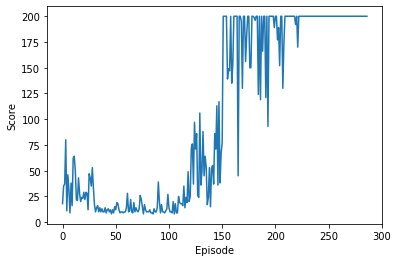

In [1]:
import os

import random
import gym
import pylab
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

#tf.config.experimental_run_functions_eagerly(True)
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import copy

EPISODES = 10000 # Number of times the enviroment is ran
LOSS_CLIPPING = 0.2 # Approximated values stated in the original paper
ENTROPY_LOSS = 0.001 # Epochs to train the network (recommended between 3 and 30)
LR = 0.001 # Learning rate 
NUM_ACTIONS = 2 # Number of possible action in the environment
NUM_STATES = 4 # Number of possible states in the exvironment
EPOCHS = 3 # Epochs to train the network (recommended between 3 and 30)
BATCH_SIZE = 64 # Batch size for the neural nets
#BUFFER_SIZE = 2048 # Buffer of experiences
SHUFFLE = True # Whether to shuffle data or not while training
OPTIMIZER = Adam # Optimizer for both actor and critic
GAMMA = 0.99 # Used for the estimated reward
LAMBDA = 0.95 # Used in the original paper un the GAE
NORMALIZE = True # Whether to normalize GAE or not



# Create the actor used to select the action given an state
class Actor_Model:
    def __init__(self):
        X_input = Input(NUM_STATES)

        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X_input)
        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
        
        # Softmax as there are different probabilities depending on the action
        output = Dense(NUM_ACTIONS, activation="softmax")(X)
        
        # Compile the model with the custom loss
        self.model = Model(inputs = X_input, outputs = output)
        self.model.compile(loss=self.ppo_loss, optimizer=OPTIMIZER(lr=LR))

    # Custom loss functions for the PPO
    def ppo_loss(self, y_true, y_pred):
        # Unpack the elements given in the true label
        advantages, true_label, actions = y_true[:, :1], y_true[:, 1:1+NUM_ACTIONS], y_true[:, 1+NUM_ACTIONS:]
        
        prob = actions * y_pred
        old_prob = actions * true_label 

        ratio = K.exp(K.log(prob + 1e-10) - K.log(old_prob + 1e-10))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

# Create the critic which will criticise how the actor is performing    
class Critic_Model:
    def __init__(self):
        X_input = Input(NUM_STATES)

        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X_input)
        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
        X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
        
        # Linear output to know how good the action is
        value = Dense(1)(X)
        
        # Compile it with mse loss and gradient descent
        self.model = Model(inputs=X_input, outputs = value)
        self.model.compile(loss='mse', optimizer=OPTIMIZER(lr=LR))

# Combine both Actor and Critic to create the agent
class PPOAgent:
    def __init__(self, env_name):
        # Environment parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.episode = 0 # used to track current number episoded since start
        self.max_average = 0 # record max average reached
        
        # Used to plot a grapgh of the train process
        self.scores_, self.average_ = [], []

        # Create Actor-Critic network models
        self.Actor = Actor_Model()
        self.Critic = Critic_Model()
    
        # Names for the models
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

    # Get the action given the current state    
    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.model.predict(state)[0]
        
        # Probability based to choose the action
        action = np.random.choice(NUM_ACTIONS, p=prediction)
        action_onehot = np.zeros([NUM_ACTIONS])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    # Generalized Advantage Estimation implemented in the original paper
    def get_gaes(self, rewards, dones, values, next_values):
        # Dones are used to track when is the final step of an episode, so next values are no applied
        deltas = [r + GAMMA * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        
        # Convert list to array as .mean() and .std() are used later
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * GAMMA * LAMBDA * gaes[t + 1]

        target = gaes + values
        if NORMALIZE:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # Reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions for state and next state
        values = self.Critic.model.predict(states)
        next_values = self.Critic.model.predict(next_states)

        # Get the advantage
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))

        # Stack info to unpack it in the custom loss
        y_true = np.hstack([advantages, predictions, actions])

        # Training Actor and Critic networks
        a_loss = self.Actor.model.fit(states, y_true, epochs=EPOCHS, verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)
        c_loss = self.Critic.model.fit(states, target, epochs=EPOCHS, verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)

 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.model.save_weights(self.Actor_name)
        self.Critic.model.save_weights(self.Critic_name)

    def run_batch(self): # train every self.Training_batch episodes
        global LR
        state = self.env.reset()
        state = np.reshape(state, [1, NUM_STATES])
        done, score = False, 0
        finished = False
        while finished == False:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            while done == False:
                #self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, NUM_STATES]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, NUM_STATES])
                score += reward
                if done:
                    self.episode += 1
                    self.scores_.append(score)
                    #average, SAVING = self.PlotModel(score, self.episode)
                    #print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, EPISODES, score, average, SAVING))
                    if self.episode >= 100:
                        average = sum(self.scores_[-100:])/100
                        print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, score, average))
                        if average > self.max_average:
                            self.max_average = average
                            if self.max_average > 150:
                                self.save()
                            LR *= 0.99
                            K.set_value(self.Actor.model.optimizer.learning_rate, LR)
                            K.set_value(self.Critic.model.optimizer.learning_rate, LR)
                            
                        if average > 195:
                            plt.plot(self.scores_)
                            plt.xlabel("Episode")
                            plt.ylabel("Score")
                            finished = True
                            break

                    else:
                        print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, score, sum(self.scores_)/len(self.scores_)))
                    
            self.replay(states, actions, rewards, predictions, dones, next_states)
            state, done, score = self.env.reset(), False, 0
            state = np.reshape(state, [1, NUM_STATES])
            
            if self.episode >= EPISODES:
                break
        self.env.close()  
                    
if __name__ == "__main__":
    start = time.time()
    env_name = 'CartPole-v0'
    agent = PPOAgent(env_name)
    #agent.run() # train as PPO, train every epesode
    agent.run_batch() # train as PPO, train every batch, trains better
    #agent.run_multiprocesses(num_worker = 8)  # train PPO multiprocessed (fastest)
    #agent.test()
    print((time.time() - start)/60)